In [75]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [76]:
df = pd.read_csv("../classify/classification_dataset.csv")
df2 = pd.read_csv("../classify/classification_dataset_two.csv")

In [77]:
df['clusters'] = df2['clusters']

In [78]:
df.sample(random_state=42,n=5)

,age,weight_kg,height_m,bmi,body_fat_percent,grip_force,sit_ups_counts,sit_and_bend_forward_m,broad_jump_m,diastolic,systolic,gender,encoded_class,clusters
10773,21,71.50,1.751,23.320279,21.1,33.0,26.0,0.103,1.82,94.0,138.0,1,3,4
5496,42,67.30,1.623,25.549242,18.0,48.5,52.0,0.152,2.19,64.0,130.0,1,0,3
13054,36,90.50,1.785,28.403518,14.7,64.0,45.0,0.264,2.62,87.0,125.0,1,2,0
11825,29,85.50,1.823,25.727215,17.7,49.5,43.0,0.122,2.54,76.0,122.0,1,3,3
1326,53,88.48,1.773,28.146710,35.6,36.3,18.0,0.064,1.83,76.0,130.0,1,3,4


## **Custom Estimators Regression**

In [79]:
import sklearn
sklearn.__version__

'1.0.2'

In [80]:
from sklearn.base import BaseEstimator,RegressorMixin, TransformerMixin,ClassifierMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

In [81]:
X = df.drop(columns=["age"])
y = df['age']

In [ ]:
# # AttributeError: 'MyScaler' object has no attribute 'factor'
# # My reason for commenting the parts of the code

# # Custom scaler
# class MyScaler(BaseEstimator,TransformerMixin):
#     # Constructor    
#     def __int__(self,factor=3):
#         self.factor = factor
    
#     # fit method 
#     def fit(self,X,y=None):
#         # fit should only take X and y as parameters
#         # Even if your model is unsupervised, you need to accept a y argument!
#         print("Done fitting")
#         return self

    
#     # transform method
#     def transform(self,X):
#         # transform takes as parameter only X
#         # Apply some transformation to X
#         return (X * self.factor)/(X + self.factor)


#     # def get_params(self, deep=True):
#     #     return {'factor': self.factor}

#     # def set_params(self, **params):
#     #     self.factor = params['factor']
#     #     return self
        

In [96]:
# Custom scaler
class MyScaler(BaseEstimator,TransformerMixin):

    # fit method 
    def fit(self,X,y=None):
        # fit should only take X and y as parameters
        # Even if your model is unsupervised, you need to accept a y argument!
        print("Transformer fitted")
        return self

    
    # transform method
    def transform(self,X):
        # transform takes as parameter only X
        # Apply some transformation to X
        return (X * 3)/(X + 3)

In [97]:
# Custom Regression
class MyLinearRegressor(BaseEstimator,RegressorMixin):
    def __init__(self):
        self.cofficients = None
        self.intercept = None

    # fit method for your algebric equation
    def fit(self,X,y):
        # Add a column of ones to X for the intercept term
        X_with_intercept = np.c_[np.ones((X.shape[0],1)),X]

        # Solve the linear regression equation to obtain the coefficients
        self.coefficients = np.linalg.inv(X_with_intercept.T.dot(X_with_intercept)).dot(X_with_intercept.T).dot(y)
        self.intercept = self.coefficients[0]
        self.coefficients = self.coefficients[1:]
        print("Regressor fitted")

        return self
    
    # predict method 
    def predict(self,X):
        # Add a column of ones to X for the intercept term
        X_with_intercept = np.c_[np.ones((X.shape[0], 1)), X]

        # Calculate the predicted values
        return X_with_intercept.dot(np.concatenate(([self.intercept], self.coefficients)))


In [98]:
def log_tranform(x):
    return np.log1p(x)

In [99]:
function_transformer = FunctionTransformer(log_tranform) # functional

In [100]:
column_transformer = ColumnTransformer(
     transformers=[
        (
            'standard_scalering',MyScaler(),[1, 4, 5, 6, 9, 10]
        ),
        (
            'functional_transformer',function_transformer,[3]
        )
    ], remainder='passthrough'
)

In [101]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cust_pipe = Pipeline([

    ('cust_column_transformer',column_transformer),
    ('reg',MyLinearRegressor())
])

# # Set the scaling factor in the pipeline
# Accessing the column transformer through the pipeline
# https://medium.com/mlearning-ai/get-column-name-after-fitting-the-machine-learning-pipeline-145a2a8051cc
# cust_pipe.named_steps['cust_column_transformer'].named_transformers_["standard_scalering"]

In [102]:
cust_pipe.fit(X_train,y_train)
y_pred = cust_pipe.predict(X_test)
rmse = mean_squared_error(y_test,y_pred)
print(f"RMSE: {rmse}")

Transformer fitted
Regressor fitted
RMSE: 109.45180783234817


## **Custom Estimators Classification**

In [144]:
X = df.drop(columns=["encoded_class"])
y = df['encoded_class']

In [145]:
class MyKNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None
        self.classes_ = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.classes_ = np.unique(y)
        return self

    def predict(self, X):
        distances = self.calculate_distances(X)
        labels = self.vote(distances)
        return labels

    def calculate_distances(self, X):
        distances = []
        for x in X:
            dist = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))
            distances.append(dist)
        return np.array(distances)

    def vote(self, distances):
        labels = []
        for dist in distances:
            indices = np.argsort(dist)[:self.k]
            k_nearest_labels = self.y_train.iloc[indices]
            unique, counts = np.unique(k_nearest_labels, return_counts=True)
            label = unique[np.argmax(counts)]
            labels.append(label)
        return np.array(labels)

In [146]:
column_transformer = ColumnTransformer(
     transformers=[
        (
            'standard_scalering',MyScaler(),[1, 4, 5, 6, 9, 10]
        ),
        (
            'functional_transformer',function_transformer,[3]
        )
    ], remainder='passthrough'
)

In [147]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cust_pipe = Pipeline([

    ('cust_column_transformer',column_transformer),
    ('clf',MyKNNClassifier())
])

In [148]:
cust_pipe.fit(X_train,y_train)

Transformer fitted


Pipeline(steps=[('cust_column_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standard_scalering',
                                                  MyScaler(),
                                                  [1, 4, 5, 6, 9, 10]),
                                                 ('functional_transformer',
                                                  FunctionTransformer(func=<function log_tranform at 0x0000022B79E45940>),
                                                  [3])])),
                ('clf', MyKNNClassifier())])

              precision    recall  f1-score   support

           0       0.70      0.88      0.78      2681
           1       0.71      0.69      0.70      2683
           2       0.77      0.72      0.75      2693
           3       0.92      0.78      0.84      2656

    accuracy                           0.77     10713
   macro avg       0.78      0.77      0.77     10713
weighted avg       0.78      0.77      0.77     10713



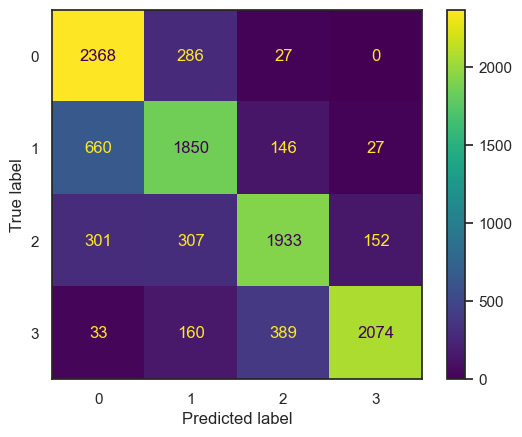

In [149]:
# Classification report
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
y_pred_train = cust_pipe.predict(X_train)

y_train = y_train
sns.set_theme(style='white')
def class_report(model,y_train,y_pred_train):
    print(classification_report(y_train,y_pred_train))
    cm = confusion_matrix(y_train,y_pred_train,labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()


class_report(cust_pipe,y_train,y_pred_train)

In [150]:
y_pred_test = cust_pipe.predict(X_test)
y_pred_test

array([2, 0, 0, ..., 0, 1, 2], dtype=int64)

              precision    recall  f1-score   support

           0       0.59      0.75      0.66       666
           1       0.47      0.45      0.46       664
           2       0.55      0.52      0.53       656
           3       0.83      0.68      0.74       693

    accuracy                           0.60      2679
   macro avg       0.61      0.60      0.60      2679
weighted avg       0.61      0.60      0.60      2679



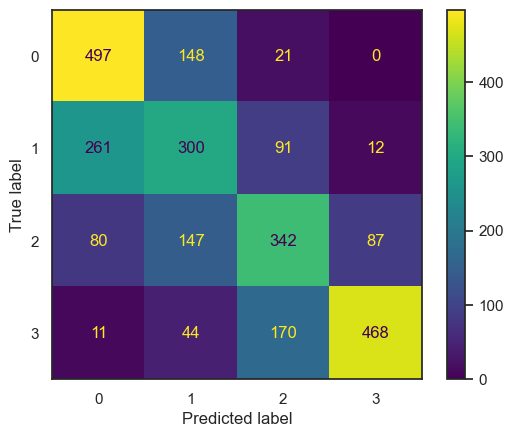

In [151]:
# Classification report
y_test = y_test
sns.set_theme(style='white')
def class_report(model,y_test,pred):
    print(classification_report(y_test,pred))
    cm = confusion_matrix(y_test,pred,labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()


class_report(cust_pipe,y_test,y_pred_test)